# Practical 1 : Implementation of Linear Regression (Ridge, Lasso)

First part:
- Implement linear regression model 
    - using least squares method
    - implement directly using the NumPy package

Second part:
- regularization
- polynomial basis expansion
- cross validation
- scikit-learn: https://scikit-learn.org/

You will need to use the following:

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cp

For the purpose of testing, we’ll use the winequality dataset. The dataset is available here:
https://archive.ics.uci.edu/ml/datasets/Wine+Quality In order to make it easier to import the dataset, we’ve converted the data to the numpy array format and shuffled it so that you can start the practical directly. The dataset is available on the course website. 

The dataset has two files. We’ll focus on the white wine data, which is the larger dataset. You can load the data from the files as follows:

In [ ]:
# load the dataset
# X is a matrix such that each row stores a data record 
# y is a vector of the corresponding labels of the records
X, y = cp.load(open('winequality-white.pickle', 'rb'))

# check the size of the data
print("X is a matrix with shape {}, which has {} records and {} attributes.".format(X.shape, X.shape[0], X.shape[1]))
print("y is a vector with {} values, which stores the corresponding labels of the data records in X".format(y.shape[0]))


X is a matrix with shape (4898, 11), which has 4898 records and 11 attributes.
y is a vector with 4898 values, which stores the corresponding labels of the data records in X


In order to get consistent results, all students should use the same 80% of the data as training
data. We’ll use the remaining as test data. To achieve this split run the following:

In [ ]:
# The function splits the dataset into the training dataset and the test dataset.
# The parameter split_coeff is a percentage value such that
# the first split_coeff of the dataset goes to the training dataset, 
# and the remaining data goes to the test dataset.
def split_data(X, y, split_coeff):
    N, _ = X.shape # get the number of records (rows)
    train_size = int(split_coeff * N) # use the first split_coeff of the data as the training data
    X_train = X[:train_size] # the first training_size records
    y_train = y[:train_size]
    X_test = X[train_size:] # the last test_size records
    y_test = y[train_size:]
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(X, y, 0.8) # use 80% of the data as training data

# check the size of the splitted dataset
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (3918, 11)
Shape of y_train: (3918,)
Shape of X_test: (980, 11)
Shape of y_test: (980,)


We’ll not touch the test data except for reporting the errors of our learned models

## Understanding What We’re Predicting

Before we get to training a linear model on the data and using it to make predictions, let’s look
at the spread of y values on the training set. The values are integers between 3 and 9 indicating
the quality of the wine.


### **Task 1**
Make a bar chart showing the distribution of y values appearing in the training data.

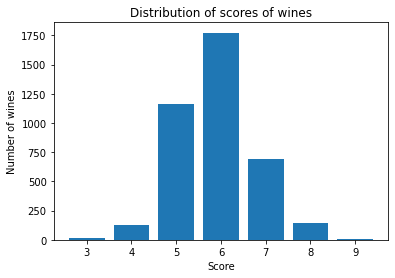

In [ ]:
#@title
# Task 1: 
# the function takes the training dataset as the input, and make the bar chart
def plot_bar_chart_score(X_train, y_train):
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    x,counts=np.unique(y_train,return_counts=True)
    plt.bar(x,counts)
    plt.title('Distribution of scores of wines')
    plt.xlabel('Score')
    plt.ylabel('Number of wines')
    plt.show()
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

plot_bar_chart_score(X_train, y_train)

### **Task 2** 
Implement the trivial predictor, which uses the average value of y on the training set as the prediction for ever datapoint. 

In [ ]:
#@title
# Task 2: implement the simplest predictor
# The function computes the average value of y on the training label values
def compute_average(y_train):
    # The code below is just for compilation. 
    # You need to delete it and write your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    return y_train.mean()
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

y_train_avg = compute_average(y_train)
print("Average of y on the training label values is {}".format(y_train_avg))

# The simplest predictor returns the average value.
def simplest_predictor(X_test, y_train_avg):
    return y_train_avg


Average of y on the training label values is 5.878764675855028


### **Task 3**
Report the mean squared error, i.e., the average of the squared residuals, using this simplest of predictors on the training and test data. We should hope that our models beat at lease this baseline. 

In [ ]:
# We will evaluate our simplest predictor here. 
# Implement a function that can report the mean squared error 
# of a predictor on the given test data
# Input: test dataset and predictor
# Output: mean squared error of the predictor on the given test data
def test_data(X_test, y_test, predictor: callable=None):
    # Applies the predictor to each row to compute the predicted values
    y_predicted = np.apply_along_axis(predictor, 1, X_test)

    # TODO: compute the mean squared error of y_predicted
    # The code below is just for compilation. 
    # You need to delete it and write your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    mse = np.square(np.subtract(y_test,y_predicted)).mean()
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    return mse

# use the above function test_data to evaluate the simplest predictor
# we use the lambda function here to pass the function simplest_predictor to the evaluator.
mse_simplest_predictor_train = test_data(X_train, y_train, lambda x: simplest_predictor(x, y_train_avg))
mse_simplest_predictor_test = test_data(X_test, y_test, lambda x: simplest_predictor(x, y_train_avg))

# Report the result
print('Simplest Predictor')
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_simplest_predictor_train)
print('MSE (Testing)  = %.4f' % mse_simplest_predictor_test)

Simplest Predictor
--------------------------------------------------------------------------------

MSE (Training) = 0.7768
MSE (Testing)  = 0.8139


## Linear Model Using Least Squares

Let us first fit a linear regression model and then calculate the training and test error. We’ll
actually use the closed form solution of the least squares estimate for the linear model. 


### **Task 4**
Is it strictly necessary to standardize the data for the linear model using the least squares method? Why?

No, it is not strictly necessary, but will be useful. First of all, it makes all numerical columns in a same scale to make sure all variables contribute equally. Secondly, Standardization assumes the data follow a Gaussian distribution, and that satisfied the assumption of linear model. 

### **Task 5**
Standardize the data, i.e., make the data for every feature have mean 0 and variance 1. 

We do the standardization using the training data, and we need to remember the means and
the standard deviations so that they can be applied to the test data as well. Apply the
standardization so that every feature in the training data has mean 0 and variance 1. Apply
the same transformation to the test data. 

In [ ]:
# Input: training data
# Output: standardize training data, standard deviations and means
def standardize_data(X):
    # TODO: compute mean, standard deviations and the standardized data
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    mean=X.mean(axis=0)
    std=X.std(axis=0)
    X_std = (X-mean)/std
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    return X_std, mean, std

X_train_std, X_train_mean, X_train_std_div = standardize_data(X_train)
print("X_train_std:", X_train_std.shape)
print("Mean:", X_train_mean)
print("Standard deviation:", X_train_std_div)

X_train_std: (3918, 11)
Mean: [6.85427514e+00 2.78390761e-01 3.34892802e-01 6.42623788e+00
 4.58213374e-02 3.53263144e+01 1.38513272e+02 9.94040729e-01
 3.18647524e+00 4.89055641e-01 1.05115799e+01]
Standard deviation: [8.39100902e-01 9.95630176e-02 1.24249975e-01 5.06377532e+00
 2.16660282e-02 1.71004677e+01 4.23956179e+01 2.97972269e-03
 1.49949475e-01 1.12992053e-01 1.22536544e+00]


In [ ]:
# TODO: Standardize the test data using the mean and standrad deviation you computed for the training data
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
X_test_std = (X_test-X_train_mean)/X_train_std_div
print(X_test_std.shape)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

(980, 11)


### **Task 6**
Implement the linear model predictor, and report the mean squared error using the linear model on the training and test data.

We will do this in several steps. We need to implement the function for computing the parameters based on the training dataset. Note we need to add the bias column to the dataset. 

In [ ]:
# the function adds a column of ones to the front of the input matrix
def expand_with_ones(X):
    # TODO: adds a column of ones to the front of the input matrix
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    X_one = np.ones((np.shape(X)[0], 1))
    X_out = np.hstack((X_one,X))
    return X_out
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

# The function computes the parameters
def least_squares_compute_parameters(X_input, y):
    # add the bias column to the dataset
    X = expand_with_ones(X_input)

    # TODO: compute the parameters based on the expanded X and y
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    X = expand_with_ones(X_input)
    T = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
    return T
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

# train the linear model parameters
w = least_squares_compute_parameters(X_train_std, y_train) 
print("w:", w.shape)

w: (12,)


We then implement the linear model predictor given the dataset and the parameters. 

In [ ]:
# Implement the linear model predictor
# Input: test data and parameters
# Output: predicted values
def linear_model_predictor(X, w):
    # TODO: compute the predicted values based on the test dataset and the parameters
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    Y_predict = np.dot(X,w)
    return Y_predict
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################


We can now evaluate our linear model predictor on the test dataset. 

In [ ]:
# use the function test_data to evaluate the linear model predictor
mse_linear_model_predictor = test_data(expand_with_ones(X_test_std), y_test, lambda x: linear_model_predictor(x, w))
print("Mean squared error is {}".format(mse_linear_model_predictor))

Mean squared error is 0.5607292042283472


## Learning Curves

Let us see if the linear model is overfitting or underfitting. Since the dataset is somewhat large and there are only 11 features, our guess should be that it may either be underfitting or be about right.

Starting with 20 datapoints, we’ll use training datasets of increasing size, in increments of 20 up to about 600 datapoints. For each case train the linear model only using the first n elements of
the training data. Calculate the training error (on the data used) and the test error (on the full test set). Plot the training error and test error as a function of the size of the dataset used for
training.

### **Task 7** 
Implement a function that evaluates the linear model over the training dataset with the input size.
The function takes a dataset and the split coefficient as inputs, and
1. splits the data to training and test datasets,
2. standardizes the data,
3. trains the linear model, and
4. reports the mse of the linear model predictor on both training and test datasets. 

In [ ]:
# Input: dataset and split coefficient
# Output: mse of the linear model predictor on both the training and test datasets
def train_and_test(X, y, split_coeff):
    # TODO: implement the function 
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    # Hints: use the functions you have implemented
    X_train2, y_train2, X_test2, y_test2 = split_data(X, y,split_coeff)
    X_train2_std, X_train2_mean, X_train2_std_div=standardize_data(X_train2)
    X_test2_std, X_test2_mean, X_test2_std_div=standardize_data(X_test2) 
    
    w = least_squares_compute_parameters(X_train2_std, y_train2) 
    
    mse_train = test_data(expand_with_ones(X_train2_std), y_train2, lambda x: linear_model_predictor(x, w))
    mse_test = test_data(expand_with_ones(X_test2_std), y_test2, lambda x: linear_model_predictor(x, w))
    return mse_train, mse_test
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

mse_train, mse_test = train_and_test(X, y, 0.8)
print('MSE using Linear Models')
print('-----------------------\n')
print('MSE (Training) = %.4f' % mse_train)
print('MSE (Testing)  = %.4f' % mse_test)


MSE using Linear Models
-----------------------

MSE (Training) = 0.5640
MSE (Testing)  = 0.5621


### **Task 8**
Report the learning curves plot. Also, explain whether you think the model is underfitting or not and how much data you need before getting the optimal test error.

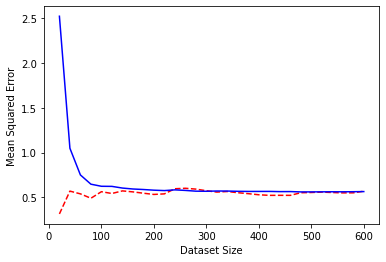

In [ ]:
mse_train_v = []
mse_test_v = []

TRAINING_SIZE_MAX = 601
TRAINING_SIZE_MIN = 20

# compute the errors over datasets with different sizes
for train_size in range(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20):
    # TODO: compute the training error and test error on datasets with size train_size
    # and add them to mse_train_v and mse_test_v, respectively
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    w = least_squares_compute_parameters(X_train_std[:train_size], y_train[:train_size]) 
    mse_train = np.mean(np.square(linear_model_predictor(expand_with_ones(X_train_std)[:train_size], w)-y_train[:train_size]))
    mse_test = np.mean(np.square(linear_model_predictor(expand_with_ones(X_test_std), w)-y_test))
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################
    mse_train_v.append(mse_train)
    mse_test_v.append(mse_test)

# The below code outputs the plot of mse from different training sizes
plt.figure(2)
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_train_v, 'r--', label="Training Error")
plt.plot(np.arange(TRAINING_SIZE_MIN, TRAINING_SIZE_MAX, 20), mse_test_v, 'b-', label="Test Error")
plt.xlabel('Dataset Size')
plt.ylabel('Mean Squared Error')
plt.show()

The model is right fitting, and the number of data is 220. With data size increases, the MSE is not decreasing. 

.

## Polynomial Basis Expansion with Ridge and Lasso

For this part use the following from the scikit-learn package. Read the documentation available here: http://scikit-learn.org/stable/modules/classes.html



You will need the use the following:

In [ ]:
# You will need the following libs. 
# Fell free to import other libs. 

# import the preprocessing libs for standarization and basis expansion
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn import linear_model
# Ridge and Lasso linear model
from sklearn.linear_model import Ridge, Lasso 

Try 5 powers of 10 for lambda from 10^-2 to 10^2 and use degree 2 basis expansion. Fit ridge and lasso using degree 2 polynomial expansion with these values of lambda. You should pick the optimal values for lambda using a validation set. Set the last 20% of the training set for the purpose of validation.

### **Task 9**
Let's implement the function for expanding the basis of the dataset. 

Hints: use `PolynomialFeatures`

In [ ]:
def expand_basis(X, degree):
    # TODO: expand the basis of X for the degree
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    poly = PolynomialFeatures(degree, include_bias=False)
    X = poly.fit_transform(X)
    return X
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

### **Task 10**
Prepare the training, test and validation data using the expanded dataset. Expand and standardize the the data. 

Hints: you can use `StandardScaler` and `std_scaler` to standardize the data

In [ ]:
# TODO: the training, test and validation data using the expanded dataset.
# The code below is just for compilation. 
# You need to replace it by your own code.
def prepare_data(X, y, degree):
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    X = expand_basis(X, degree)
    scaler = preprocessing.StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    N, _ = X_scaled.shape # get the number of records (rows)
    train_size = int(0.8 * N) # use the first split_coeff of the data as the training data
     # training data
    X_train = X_scaled[:train_size] # the first training_size records
    y_train = y[:train_size]
     # test data
    X_test = X_scaled[train_size:] # the last test_size records
    y_test = y[train_size:]

    # further split the training data to training and validation data
    X_train_n, y_train_n, X_train_v, y_train_v = split_data(X_train, y_train, 0.8)

    # further split the training data to training and validation data
    # training data
    N1, _ = X_train.shape # get the number of records (rows)
    train_size1 = int(0.8 * N1)
    X_train_n = X_train[:train_size1]
    y_train_n = y_train[:train_size1]
    
    # validation data
    X_train_v = X_train[train_size1:]
    y_train_v = y_train[train_size1:]

    return X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################

X_train, y_train, X_train_n, y_train_n, X_train_v, y_train_v, X_test, y_test = prepare_data(X, y, 2) # here we expand the dataset with degree 2

### **Task 11**
We have prepared the training data and the validation data. We can now choose the hyper parameter lambda for Ridge and Lasso using the validation data. 


Ridge lambda: 0.01
Lasso lambda: 0.01


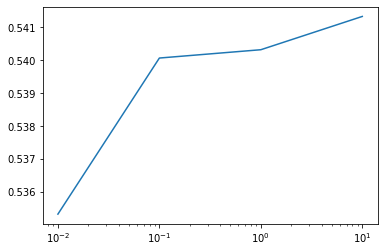

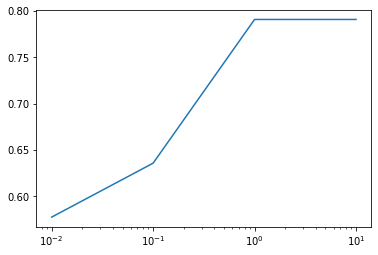

In [ ]:
# The function takes the training and validation data as inputs, and 
# returns the lambda value that has the minimal mse
# We use is_ridge to indicate the model we consider. 
# is_ridge = True indicates Ridge while is_ridge = False indicates Lasso
def choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, is_ridge: bool):
    mse_arr = []
    lam_arr = []

    # Try lambda values from 10^-2 to 10^2. 
    # Record the mse and the lambda values in mse_arr and lam_arr
    # The code below is just for compilation. 
    # You need to replace it by your own code.
    ###################################################
    ##### YOUR CODE STARTS HERE #######################
    ###################################################
    for pow_lam in range(-2, 2):
        lam = 10 ** pow_lam
        if is_ridge == True:
            model_ridge = Ridge(alpha=lam)
            y_ridge_predicted = model_ridge.fit(X_train_n, y_train_n).predict(X_train_n)
            w = least_squares_compute_parameters(X_train_n, y_ridge_predicted) 
        else: 
            model_lasso = Lasso(alpha=lam)
            y_lasso_predicted = model_lasso.fit(X_train_n, y_train_n).predict(X_train_n)
            w = least_squares_compute_parameters(X_train_n, y_lasso_predicted) 
        
        mse = test_data(expand_with_ones(X_train_v), y_train_v, lambda x: linear_model_predictor(x, w))
        mse_arr.append(mse) # add the mse when using the hyperparameter lam
        lam_arr.append(lam)
    ###################################################
    ##### YOUR CODE ENDS HERE #########################
    ###################################################


    # get the index of the lambda value that has the minimal use
    lambda_idx_min = np.argmin(np.array(mse_arr))
    # print(lam_arr[lambda_idx_min])

    # plot of the lambda values and their mse
    plt.figure()
    plt.semilogx(lam_arr, mse_arr)

    # return the best lambda value
    return lam_arr[lambda_idx_min]

# call the function to choose the lambda for Ridge and Lasso
lam_ridge = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, True)
lam_lasso = choose_hyper_param(X_train_n, y_train_n, X_train_v, y_train_v, False)

print("Ridge lambda:", lam_ridge)
print("Lasso lambda:", lam_lasso)

### **Task 12**:
Once you’ve obtained the optimal values for lambda for Ridge and Lasso, train these models using these hyperparameters on the full training data. Then report
the training and test error.

In [ ]:
# TODO: train the Ridge and Lasso models using their best parameters, and
#       report their mse
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
model_ridge = Ridge(alpha=lam_ridge)
model_ridge.fit(X_train, y_train)
mse_ridge_train = mean_squared_error(y_train, model_ridge.predict(X_train))
mse_ridge_test = mean_squared_error(y_test, model_ridge.predict(X_test))

model_lasso = Lasso(alpha=lam_lasso)
model_lasso.fit(X_train, y_train) 
mse_lasso_train = mean_squared_error(y_train, model_lasso.predict(X_train))
mse_lasso_test = mean_squared_error(y_test, model_lasso.predict(X_test))
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (2, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)

For Ridge Regression with using degree 2 polynomial expansion and lambda = 0.0100
--------------------------------------------------------------------------------

MSE (Training) = 0.5014
MSE (Testing)  = 0.5161


For Lasso with using degree 2 polynomial expansion and lambda = 0.0100
---------------------------------------------------------------------

MSE (Training) = 0.5489
MSE (Testing)  = 0.5422


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.639680512979794, tolerance: 0.3043413221031145
  positive)


## Larger Degrees



### **Task 13**
Try using higher degree basis expansion. You may want to use k-fold cross validation to determine
the values of hyperparameters rather than just keeping a validation set. 

Hints: Use `KFold` to do this automatically. 

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.47380730263239457, tolerance: 0.3454274954627946
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.45220183082983567, tolerance: 0.3469309437386567
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.3622527015872947, tolerance: 0.35048239564428196
  positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.4

For Ridge Regression with using degree 10 polynomial expansion and lambda = 10.0000
--------------------------------------------------------------------------------

MSE (Training) = 0.4751
MSE (Testing)  = 0.5075


For Lasso with using degree 0 polynomial expansion and lambda = 0.0100
---------------------------------------------------------------------

MSE (Training) = 0.5363
MSE (Testing)  = 0.5405


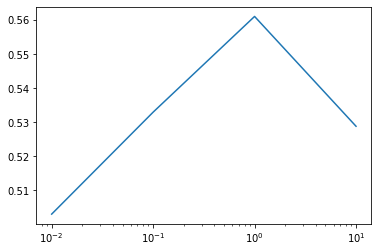

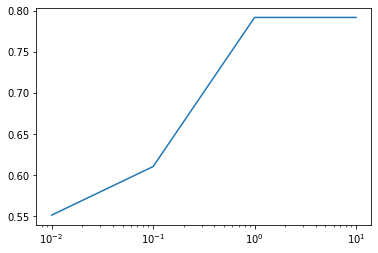

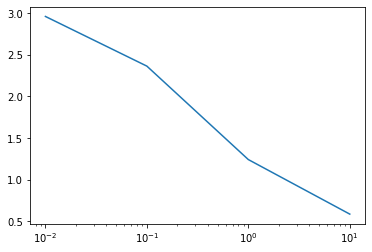

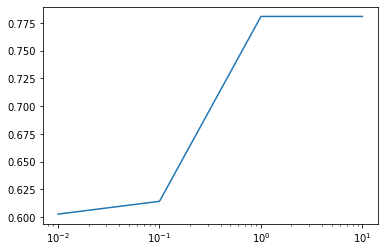

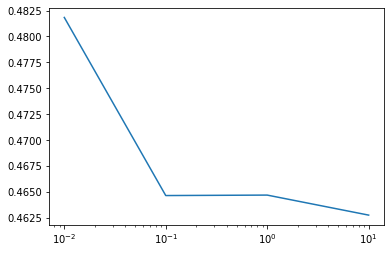

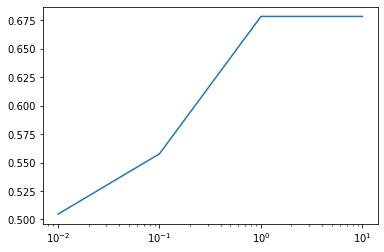

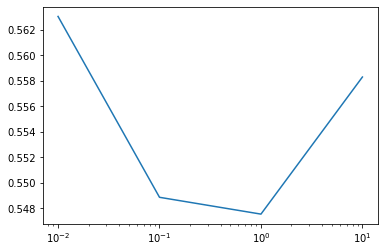

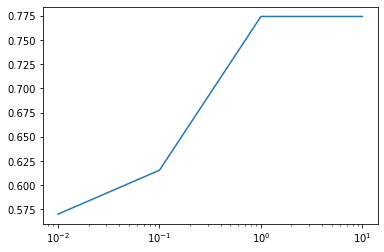

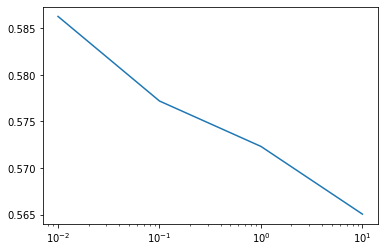

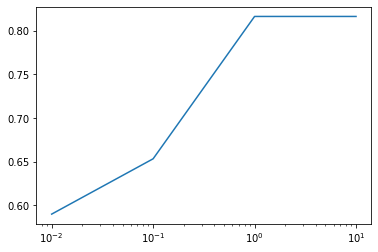

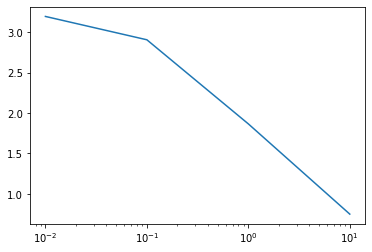

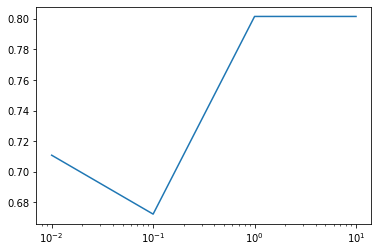

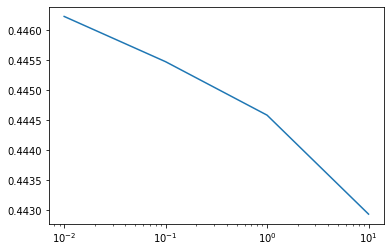

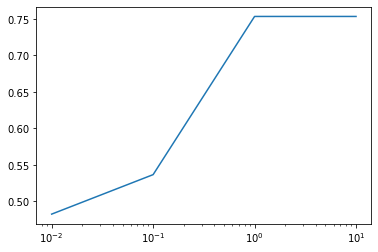

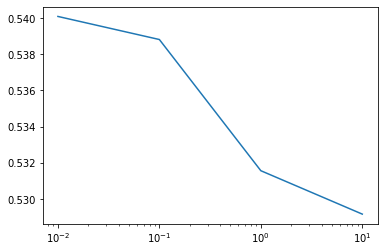

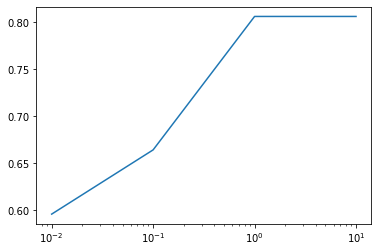

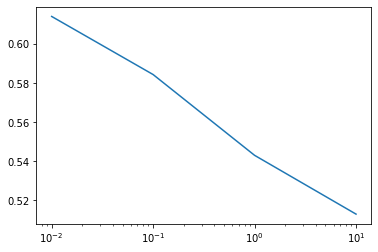

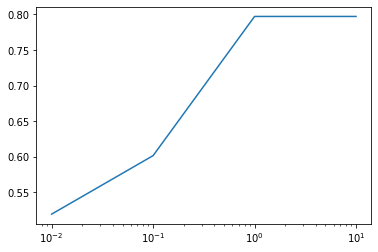

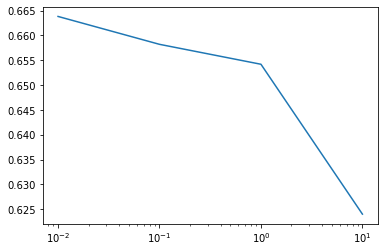

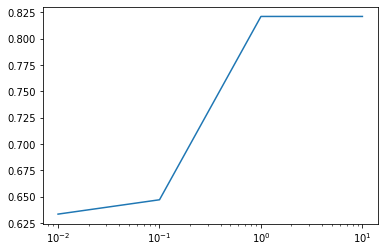

In [ ]:
# TODO: Try using higher degree basis expansion. Find the degree that gives the minimal mse. 
###################################################
##### YOUR CODE STARTS HERE #######################
###################################################
from sklearn.model_selection import KFold
X = expand_basis(X, 3)
scaler = StandardScaler()
X = scaler.fit_transform(X)

kf = KFold(n_splits=10)
kf.get_n_splits(X)
#print(kf)

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    lam_ridge = choose_hyper_param(X_train, y_train, X_test, y_test, True)
    lam_lasso = choose_hyper_param(X_train, y_train, X_test, y_test, False)
   # print("Ridge lambda:", lam_ridge)
    #print("Lasso lambda:", lam_lasso)
    
ridge = Ridge(alpha=lam_ridge)
ridge.fit(X_train, y_train)

mse_ridge_train = mean_squared_error(y_train, ridge.predict(X_train))
mse_ridge_test = mean_squared_error(y_test, ridge.predict(X_test))

lasso = Lasso(alpha=lam_lasso) 
lasso.fit(X_train,y_train)

mse_lasso_train = mean_squared_error(y_train, lasso.predict(X_train))
mse_lasso_test = mean_squared_error(y_test, lasso.predict(X_test))

# Report the result
print('For Ridge Regression with using degree %d polynomial expansion and lambda = %.4f' % (lam_ridge, lam_ridge))
print('--------------------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_ridge_train)
print('MSE (Testing)  = %.4f' % mse_ridge_test)

print('\n\nFor Lasso with using degree %d polynomial expansion and lambda = %.4f' % (lam_lasso, lam_lasso))
print('---------------------------------------------------------------------\n')
print('MSE (Training) = %.4f' % mse_lasso_train)
print('MSE (Testing)  = %.4f' % mse_lasso_test)
###################################################
##### YOUR CODE ENDS HERE #########################
###################################################

## Short Report

In this practical, we have implemented a linear regression model on the Wine dataset. By the method of Mean Square Least, the best parameter "w" has been calculated. The MSE of training data is 0.5640, and the MSE of testing data is 0.5621. However, by ploting the learning curve, we have found it is right fitting, and the optimal number of data size is 220. Later on, we implemented polynomial basis expansion and regularization. The optimal value of hyperparameter lambda was tuned as 0.01. By Ridge regularization, the MSE of training data is 0.5014 and the MSE of testing data is 0.5161. By Lasso regularization, the MSE od training data is 0.5489 and the MSE of tseting data is 0.5422.
 
Implemening different degrees of polinomial expansion(from degree 1 to degree 5). For ridge regression, the MSE of both training and test data decreased from degree 1 to degree3; starting from degree 4, MSE of test data increased while MSE of training data decreased. For Lasso, both MSE of training and test data decreased from degree 1 to degree3, also both increased from degree 4. Therefore, the degree 3 that gives minimal MSE. (Records listed below)

It was difficult for us to run in higher degrees, thus we cannot know what will show in higher degress. 

For this practical, each of us has done all tasks on our own, compared and chose the best result we all agreed on. 
__________

For Ridge Regression with using degree 1 polynomial expansion and lambda = 0.0100
MSE (Training) = 0.5639 MSE (Testing) = 0.5611
For Lasso with using degree 1 polynomial expansion and lambda = 0.0100
MSE (Training) = 0.5679 MSE (Testing) = 0.5669

__________
For Ridge Regression with using degree 2 polynomial expansion and lambda = 0.0100
MSE (Training) = 0.5015 MSE (Testing) = 0.5143

For Lasso with using degree 2 polynomial expansion and lambda = 0.0100
MSE (Training) = 0.5459 MSE (Testing) = 0.5530

___________
For Ridge Regression with using degree 3 polynomial expansion and lambda = 10.0000
MSE (Training) = 0.4751 MSE (Testing) = 0.5075

For Lasso with using degree 3 polynomial expansion and lambda = 0.0100
MSE (Training) = 0.5363 MSE (Testing) = 0.5405

__________
For Ridge Regression with using degree 4 polynomial expansion and lambda = 10.0000
MSE (Training) = 0.4523 MSE (Testing) = 0.5404

For Lasso with using degree 4 polynomial expansion and lambda = 1.0000
MSE (Training) = 0.7824 MSE (Testing) = 0.8002

__________
For Ridge Regression with using degree 5 polynomial expansion and lambda = 0.1000
MSE (Training) = 0.3515 MSE (Testing) = 0.7858

For Lasso with using degree 5 polynomial expansion and lambda = 1.0000
MSE (Training) = 0.7824 MSE (Testing) = 0.8002
